# Task 1

1. Split the training set into a training subset and a validation subset with the data number proportion about 9:1.The training subset and the validation subset should have similar ratios of the four classes. Statistics of the ratios should be presented.

In [26]:
import numpy as np
import pandas as pd
from numpy import dot
from numpy.linalg import norm

import re

#import libraries for data processing
import nltk
from nltk import FreqDist, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

#import libraries for vectorisation
import gensim
from gensim.models import Word2Vec

#train validation set split
from sklearn.model_selection import train_test_split

#cosice distance
from sklearn.metrics.pairwise import paired_cosine_distances

#Counter for count word frequency
from collections import Counter

#import tqdm for feature construction
from tqdm import tqdm

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
sns.set_style("white")  

#math for calculation
import math


#import the training set and test set
Train_body = pd.read_csv('/Users/weisihan/Downloads/fnc-1-master/train_bodies.csv')
Train_stance = pd.read_csv('/Users/weisihan/Downloads/fnc-1-master/train_stances.csv')
Test_body = pd.read_csv('/Users/weisihan/Downloads/fnc-1-master/competition_test_bodies.csv')
Test_stance = pd.read_csv('/Users/weisihan/Downloads/fnc-1-master/competition_test_stances.csv')

In [27]:
Train_body.head()

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [28]:
Train_stance.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [29]:
#Change the name of trainingset column 'Body ID' to 'Body_ID'
Train_stance.rename(columns={'Body ID':'Body_ID'}, inplace=True) 
Train_body.rename(columns={'Body ID':'Body_ID'}, inplace=True) 
#Merge table Train_stance and Train_body
Train_df = pd.merge(Train_stance, Train_body, how='inner', on="Body_ID",  copy=True)  
#Change the sequence of column for better view hehe
Train_df=Train_df[['Headline', 'Body_ID', 'articleBody','Stance']]
Train_df.shape

(49972, 4)

In [30]:
#Change the name of testset column 'Body ID' to 'Body_ID'
Test_stance.rename(columns={'Body ID':'Body_ID'}, inplace=True) 
Test_body.rename(columns={'Body ID':'Body_ID'}, inplace=True) 
#Merge table Train_stance and Train_body
Test_df = pd.merge(Test_stance, Test_body, how='inner', on="Body_ID",  copy=True)  
#Change the sequence of column for better view hehe
Test_df=Test_df[['Headline', 'Body_ID', 'articleBody']]
Test_df['Stance']='NAN'
Test_df.shape

(25413, 4)

In [31]:
Train_df['articleBody'].describe()

count                                                 49972
unique                                                 1669
top       The man who jumped the White House fence this ...
freq                                                    187
Name: articleBody, dtype: object

In [32]:
Train_df['Headline'].describe()

count                                             49972
unique                                             1648
top       ISIL Beheads American Photojournalist in Iraq
freq                                                127
Name: Headline, dtype: object

In [33]:
# define a function to count the number of different stance class
from collections import Counter

def Stance_classes(df):
    col='Stance'
    stances_num = Counter(df[col])
    stances_df = pd.DataFrame.from_dict(stances_num, orient='index')
    stances_df.columns = ['count']
    stances_df = stances_df.sort_values(['count'], ascending=False)
    total_stance_num = 0
    for index, row in stances_df.iterrows():
        total_stance_num += row['count']
    stances_df['%counts'] = round(stances_df['count']/total_stance_num*100)
    #stances_data['count'].plot(kind='bar')
    print(stances_df)

In [34]:
Train_stances_df = Stance_classes(Train_df)
#Test_stances_df = Stance_classes(Test_df)

           count  %counts
unrelated  36545     73.0
discuss     8909     18.0
agree       3678      7.0
disagree     840      2.0


In [35]:
def trts_split(df):
    tts_df = df.copy()
    X = tts_df[['Headline','Body_ID','articleBody']]
    y = tts_df['Stance']
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=123)
    Xy_train = pd.concat([X_train,y_train],axis=1)
    Xy_valid = pd.concat([X_valid,y_valid],axis=1)
    return  Xy_train, Xy_valid

In [36]:
All_agree = Train_df[Train_df['Stance']=='agree']
All_disagree = Train_df[Train_df['Stance']=='disagree']
All_discuss = Train_df[Train_df['Stance']=='discuss']
All_unrelated = Train_df[Train_df['Stance']=='unrelated']

In [37]:
Train_df_agree, Valid_df_agree = trts_split(All_agree)
Train_df_disagree, Valid_df_disagree = trts_split(All_disagree)
Train_df_discuss, Valid_df_discuss = trts_split(All_discuss)
Train_df_unrelated, Valid_df_unrelated = trts_split(All_unrelated)

Train_set = pd.concat([Train_df_agree,Train_df_disagree,Train_df_discuss,Train_df_unrelated])
Valid_set = pd.concat([Valid_df_agree,Valid_df_disagree,Valid_df_discuss,Valid_df_unrelated])
print(Train_set.count(),Valid_set.count())

Headline       44974
Body_ID        44974
articleBody    44974
Stance         44974
dtype: int64 Headline       4998
Body_ID        4998
articleBody    4998
Stance         4998
dtype: int64


In [38]:
Train_set.groupby('Stance').count()

,Headline,Body_ID,articleBody
Stance,,,
agree,3310,3310,3310
disagree,756,756,756
discuss,8018,8018,8018
unrelated,32890,32890,32890


In [42]:
Valid_set.groupby('Stance').count()

,Headline,Body_ID,articleBody
Stance,,,
agree,368,368,368
disagree,84,84,84
discuss,891,891,891
unrelated,3655,3655,3655


In [39]:
Train_ratio = Train_set.groupby('Stance').count()['Body_ID'] / (Train_set.groupby('Stance').count()['Body_ID']).sum()
Valid_ratio = Valid_set.groupby('Stance').count()['Body_ID'] / (Valid_set.groupby('Stance').count()['Body_ID']).sum()

TR = list(Train_ratio)
VR = list(Valid_ratio)
print('The ratio of the four class in trainning set is:  Agree: %f, Disagree: %f, Discuss: %f, Unrelated: %f' %(TR[0],TR[1],TR[2],TR[3]) )
print('The ratio of the four class in validation set is: Agree: %f, Disagree: %f, Discuss: %f, Unrelated: %f' %(VR[0],VR[1],VR[2],VR[3]) )


The ratio of the four class in trainning set is:  Agree: 0.073598, Disagree: 0.016810, Discuss: 0.178281, Unrelated: 0.731311
The ratio of the four class in validation set is: Agree: 0.073629, Disagree: 0.016807, Discuss: 0.178271, Unrelated: 0.731293


/Users/weisihan/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:326: UserWarning: Unrecognized location "bests". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


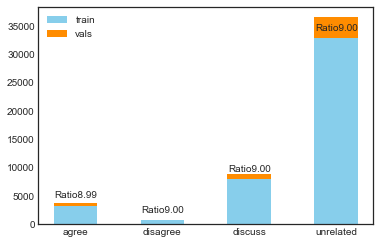

In [58]:
agree_train=Train_set.groupby('Stance').count()['Body_ID'][0]
disagree_train=Train_set.groupby('Stance').count()['Body_ID'][1]
discuss_train=Train_set.groupby('Stance').count()['Body_ID'][2]
unrelated_train=Train_set.groupby('Stance').count()['Body_ID'][3]

agree_valid=Valid_set.groupby('Stance').count()['Body_ID'][0]
disagree_valid=Valid_set.groupby('Stance').count()['Body_ID'][1]
discuss_valid=Valid_set.groupby('Stance').count()['Body_ID'][2]
unrelated_valid=Valid_set.groupby('Stance').count()['Body_ID'][3]

catgory=['agree','disagree','discuss','unrelated']
train = np.array([agree_train,disagree_train,discuss_train,unrelated_train])
val = np.array([agree_valid,disagree_valid,discuss_valid,unrelated_valid])

x = np.arange(len(catgory))
width = 0.5
fig,ax =plt.subplots()
b1=ax.bar(x,train,width,color='skyblue')
b2=ax.bar(x,val,width,train,color='darkorange')
ax.set_xticks(x)
ax.set_xticklabels(catgory)
ax.legend(('train', 'vals'),loc="bests")

value=[agree_train/agree_valid,disagree_train/disagree_valid,discuss_train/discuss_valid,unrelated_train/unrelated_valid]


count=0
for rect in b1:
    h=rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2,h+1000,'Ratio%.2f'%value[count],ha='center',va='bottom')
    count+=1

plt.show()


In [40]:
Train_set.head()

,Headline,Body_ID,articleBody,Stance
21984,Apple Watch Battery Life Currently 'About a Da...,2213,"On Tuesday, Apple unveiled its first wearable ...",agree
37301,Devoted pet owner spends £300 to save his GOLD...,1707,A devoted pet owner has spent £300 on saving t...,agree
43316,Texas plumber's truck spotted in Syria: 'We ha...,2242,A Texas plumber is getting death threats after...,agree
31986,ISIS executioner 'Jihadi John' identified as M...,1198,ISIS video screenshot\n\nWhat We Know So Far\n...,agree
39781,"No, Banksy Didn't Create That 'Charlie Hebdo' ...",1357,There's an illustration being shared on Facebo...,agree


In [41]:
Valid_set.head()

,Headline,Body_ID,articleBody,Stance
47914,Tiger Woods' former luxury island goes on sale,1991,"Golfers, take note — Tiger Woods’ Swedish luxu...",agree
47955,Jilted lover spends a week in KFC to try and g...,1551,We’ve all had that feeling of being jilted by ...,agree
23222,I aborted my baby because it was a boy,1494,I aborted my baby because it was a boy,agree
18332,Is the Alleged Audio of the Gunshots That Kill...,1776,Former LAPD officer David Klinger and CNN law ...,agree
49918,Planetary Alignment Decrease Gravity Hoax on J...,1377,An article saying a “planetary alignment” on J...,agree
